# Compute optimal individual parameters for GMAC metric

In [2]:
from zurich_move_data_extraction import *
from activity_count_function import *
from utilities import *
from gm_function import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from individual_analysis_fs_functions import *
from group_analysis_functions import *
from classification_algorithms import compute_vector_magnitude
import GMAC as gmac

/Users/linus/Code/imu_processing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#CHANGE VALUES HERE TODO
# H for Healthy and S for Stroke 
participant_id = 'S008'
participant_group = 'S'
using_Axivity = True

In [4]:
#PATH# 
initial_path = '../data/CreateStudy'#'../CreateStudy'
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../data/CreateStudy/S008


In [5]:
# Extract dataset from the participant JSON file 
participant_data = load_participant_json(participant_id, initial_path)
# Get the correct handiness 
# For stroke, dominant hand = non affected hand 
dominant_hand = get_dominant_hand(participant_data)

In [6]:
# Get the data from IMU csv files 
ndh_data, chest_data, dh_data, GT_mask_25Hz_NDH, GT_mask_25Hz_DH = get_data(participant_path, dominant_hand, using_Axivity)
GT_mask_25Hz_NDH = GT_mask_25Hz_NDH.ravel()
GT_mask_25Hz_DH = GT_mask_25Hz_DH.ravel()
# Ensure the array sizes consistency between masks and IMU data
print(len(GT_mask_25Hz_NDH)*2, len(ndh_data))

99246 99246


In [7]:
sampling_freq = 50 # Hz
frequency_GMAC = 1 # Hz
FPS_mask = 25 # Hz
frequency_euler_angles = 50 # Hz 

Remove data during frames which were labeled for exclusion due to invisibility of arm/hand.

In [8]:
# Upsample GT (50 Hz)
GT_mask_NDH_50Hz = resample_mask(GT_mask_25Hz_NDH, FPS_mask, frequency_euler_angles)
GT_mask_DH_50Hz = resample_mask(GT_mask_25Hz_DH, FPS_mask, frequency_euler_angles)

In [9]:
# Get useful variables
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
if not using_Axivity:
    mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
    quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
    quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]

## compute GMAC Counts and pitch

### Vector Magnitude


In [10]:
#https://github.com/biorehab/upper-limb-use-assessment/tree/main
df_for_Subash_ndh = ndh_data.rename(columns={'acc_x': 'ax', 'acc_y': 'ay', 'acc_z': 'az', 'gyro_x': 'gx', 'gyro_y': 'gy', 'gyro_z': 'gz'})
df_for_Subash_dh = dh_data.rename(columns={'acc_x': 'ax', 'acc_y': 'ay', 'acc_z': 'az', 'gyro_x': 'gx', 'gyro_y': 'gy', 'gyro_z': 'gz'})

# Convert timestamp column to datetime format (assuming 'timestamp' is in a suitable format)
df_for_Subash_ndh['timestamp'] = pd.to_datetime(df_for_Subash_ndh['timestamp'])
df_for_Subash_dh['timestamp'] = pd.to_datetime(df_for_Subash_dh['timestamp'])
# Set the index of the DataFrame to the timestamp column
df_for_Subash_ndh.set_index('timestamp', inplace=True)
df_for_Subash_dh.set_index('timestamp', inplace=True)
# Remove the time column
df_for_Subash_ndh.drop('time', axis=1, inplace=True)
df_for_Subash_dh.drop('time', axis=1, inplace=True)

counts_for_GMAC_ndh = np.array(compute_vector_magnitude(df_for_Subash_ndh))
counts_for_GMAC_dh = np.array(compute_vector_magnitude(df_for_Subash_dh))

/Users/linus/Code/imu_processing/src/classification_algorithms.py:61: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:61: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:98: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(1) + 'S').sum() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:61: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', labe

### Euler angles

In [11]:
# Get Euler angles usign Madgwick sensor fusiona algorithm 
# Using only accel. and gyro 
# MARG uses also magnetometer but after testing, it was less precise 
# Left wrist
_, pitch_mad_ndh, _ = compute_euler_angles(acc_ndh, gyro_ndh, sampling_freq)
# Right wrist 
_, pitch_mad_dh, _ = compute_euler_angles(acc_dh, gyro_dh, sampling_freq)

Using IMU Madgwick with acc and gyro only
Using IMU Madgwick with acc and gyro only


In [12]:
# Ensure the datasets have the same sizes 
# For ndh
pitch_mad_ndh, GT_mask_50Hz_ndh = remove_extra_elements(pitch_mad_ndh, GT_mask_NDH_50Hz)
# For dh
pitch_mad_dh, GT_mask_50Hz_dh = remove_extra_elements(pitch_mad_dh, GT_mask_DH_50Hz)

Arrays already had same shape.
Arrays already had same shape.


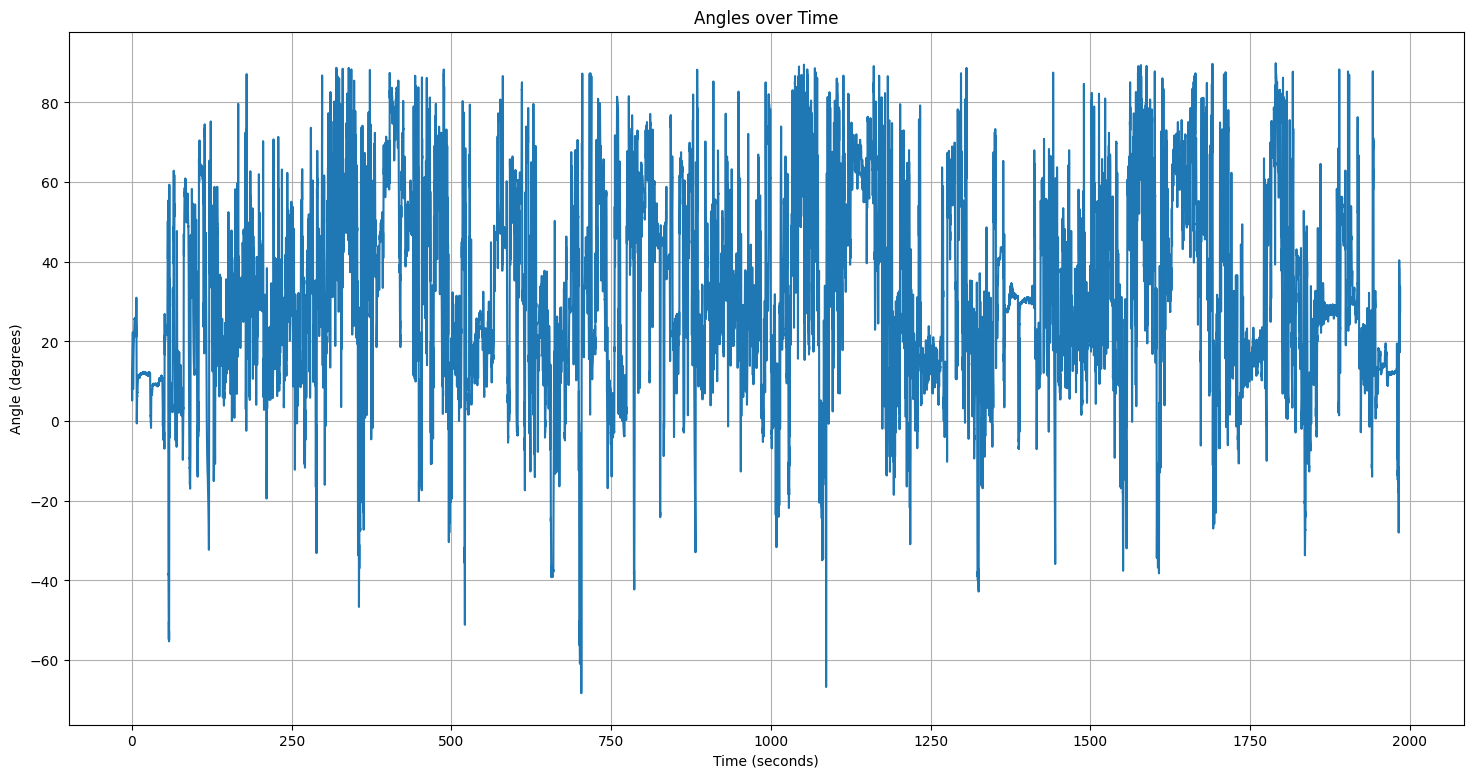

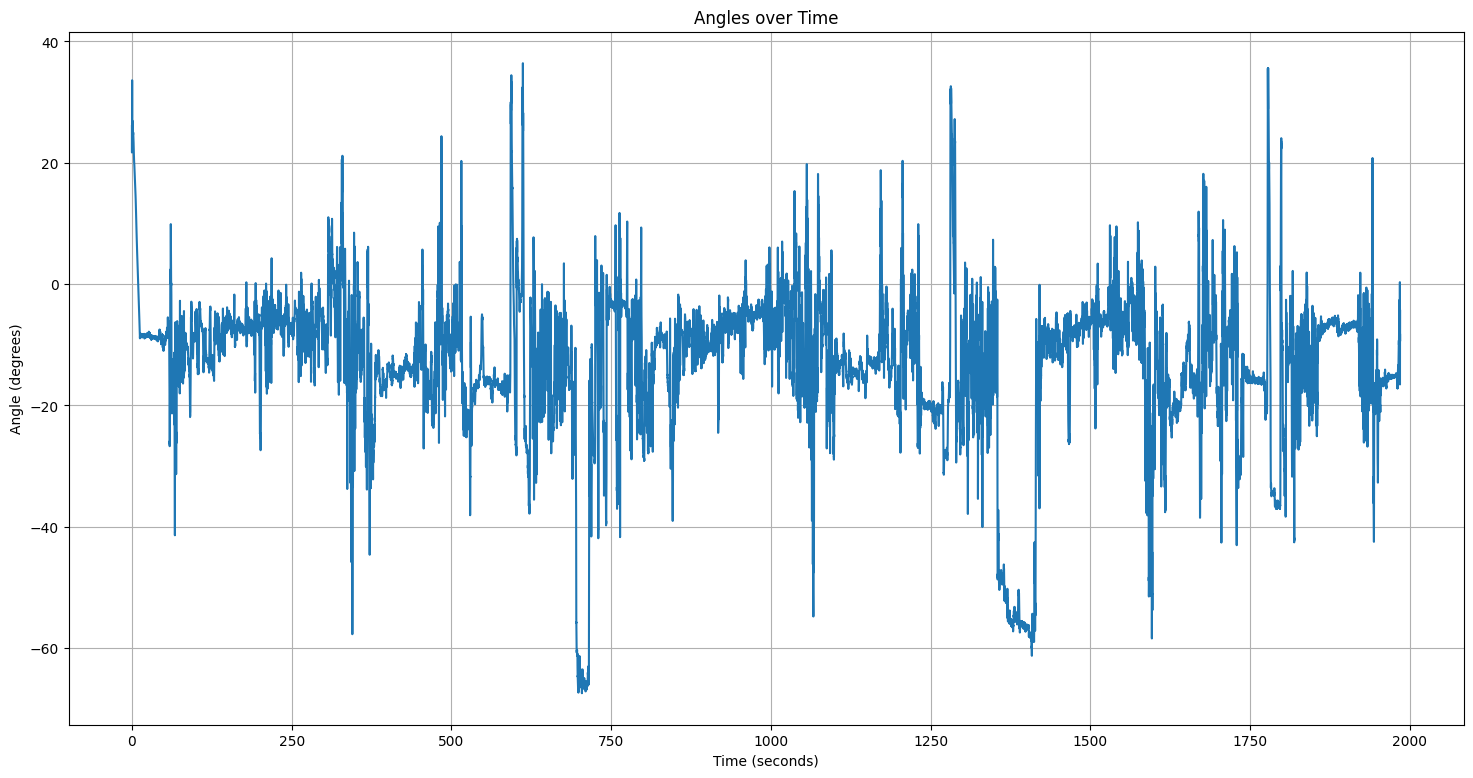

In [13]:
plot_angles_over_time(pitch_mad_dh)
plot_angles_over_time(pitch_mad_ndh)

In [14]:
# Add Euler angles to participant dataset
add_attributes_to_participant(participant_data, pitch_NDH=pitch_mad_ndh, pitch_DH=pitch_mad_dh)

Resample pitch to 1Hz

In [15]:
df_for_Subash_ndh['pitch'] = pitch_mad_ndh
df_for_Subash_dh['pitch'] = pitch_mad_dh

In [16]:
mean_pitch_NDH = gmac.resample(df_for_Subash_ndh[['pitch']], 50, 1)
mean_pitch_DH = gmac.resample(df_for_Subash_dh[['pitch']], 50, 1)

/Users/linus/Code/imu_processing/src/GMAC.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/GMAC.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]


### GT MASK Resampling & dropping of excluded frames

In [17]:
# Replace all WBM (whole-body movements) by NF movements inside the GT mask @ 25 Hz 
# Could be changed in the future (e.g. remove all WBM movements)
GT_mask_NDH_25Hz = replace_wbm_with_nf(GT_mask_25Hz_NDH).ravel()
GT_mask_DH_25Hz = replace_wbm_with_nf(GT_mask_25Hz_DH).ravel()

In [18]:
# Downsample GT masks to be used later on for GMAC (1Hz) computation
GT_mask_NDH_1Hz = downsample_mask(GT_mask_NDH_25Hz, FPS_mask, frequency_GMAC)
GT_mask_DH_1Hz = downsample_mask(GT_mask_DH_25Hz, FPS_mask, frequency_GMAC)

Arrays already had same shape.
Arrays already had same shape.


In [21]:
# Ensure GT Mask @ 1 hZ have same size as the vector magnitude values 
GT_mask_NDH_1Hz, counts_for_GMAC_ndh = remove_extra_elements(GT_mask_NDH_1Hz, counts_for_GMAC_ndh)
GT_mask_DH_1Hz, counts_for_GMAC_dh = remove_extra_elements(GT_mask_DH_1Hz, counts_for_GMAC_dh)
# Ensure GT Mask @ 1 hZ have same size as the pitch values
GT_mask_NDH_1Hz, mean_pitch_NDH = remove_extra_elements(GT_mask_NDH_1Hz, mean_pitch_NDH)
GT_mask_DH_1Hz, mean_pitch_DH = remove_extra_elements(GT_mask_DH_1Hz, mean_pitch_DH)
GT_mask_NDH_1Hz, counts_for_GMAC_ndh = remove_extra_elements(GT_mask_NDH_1Hz, counts_for_GMAC_ndh)
GT_mask_DH_1Hz, counts_for_GMAC_dh = remove_extra_elements(GT_mask_DH_1Hz, counts_for_GMAC_dh)

Array 2 has been trimmed to size 1985.
Array 2 has been trimmed to size 1985.
Arrays already had same shape.
Arrays already had same shape.
Arrays already had same shape.
Arrays already had same shape.


remove excluded frames

In [22]:
counts_for_GMAC_ndh, mean_pitch_NDH, GT_mask_NDH_1Hz = remove_excluded_frames(counts_for_GMAC_ndh, mean_pitch_NDH, GT_mask_NDH_1Hz)
counts_for_GMAC_dh, mean_pitch_DH, GT_mask_DH_1Hz = remove_excluded_frames(counts_for_GMAC_dh, mean_pitch_DH, GT_mask_DH_1Hz)

remove nan frames due to filtering in counts

In [23]:
counts_for_GMAC_ndh, mean_pitch_NDH, GT_mask_NDH_1Hz = remove_nan_frames(counts_for_GMAC_ndh, mean_pitch_NDH, GT_mask_NDH_1Hz)
counts_for_GMAC_dh, mean_pitch_DH, GT_mask_DH_1Hz = remove_nan_frames(counts_for_GMAC_dh, mean_pitch_DH, GT_mask_DH_1Hz)

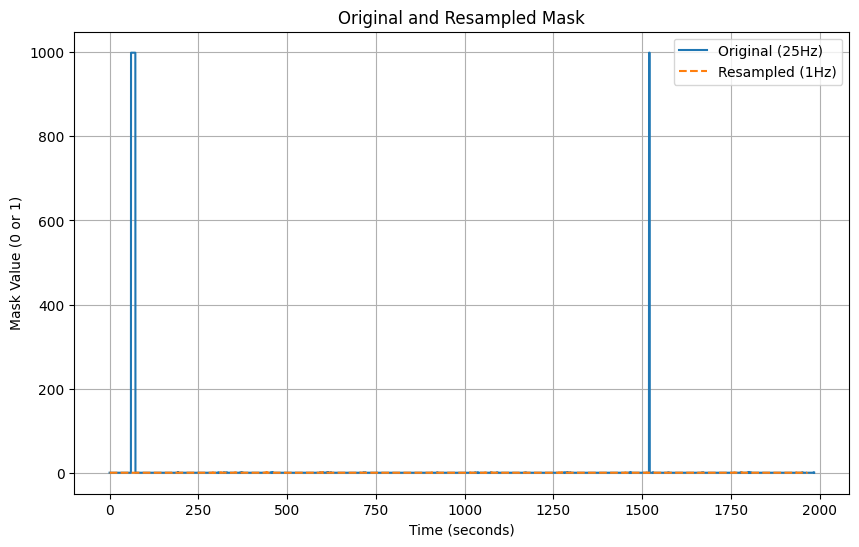

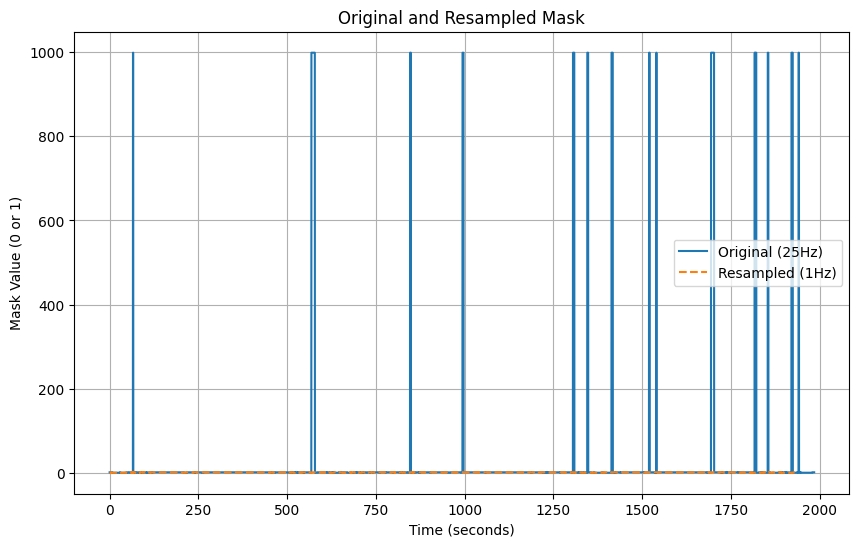

In [24]:
# Plots to ensure the downsampling was correctly done
plot_resampled_arrays(GT_mask_NDH_25Hz, FPS_mask, GT_mask_NDH_1Hz, frequency_GMAC) #TODO plots don't seem correct
plot_resampled_arrays(GT_mask_DH_25Hz, FPS_mask, GT_mask_DH_1Hz, frequency_GMAC)

In [25]:
# Update the participant dataset file with new arrays of usefull data  
# Add vector magnitude
add_attributes_to_participant(participant_data, counts_for_GMAC_ndh=counts_for_GMAC_ndh, counts_for_GMAC_dh=counts_for_GMAC_dh)
# Add mask @ 1 Hz and @ 25 Hz
add_attributes_to_participant(participant_data, GT_mask_NDH_1Hz = GT_mask_NDH_1Hz, GT_mask_DH_1Hz = GT_mask_DH_1Hz, 
                             GT_mask_NDH_25Hz = GT_mask_NDH_25Hz, GT_mask_DH_25Hz = GT_mask_DH_25Hz)

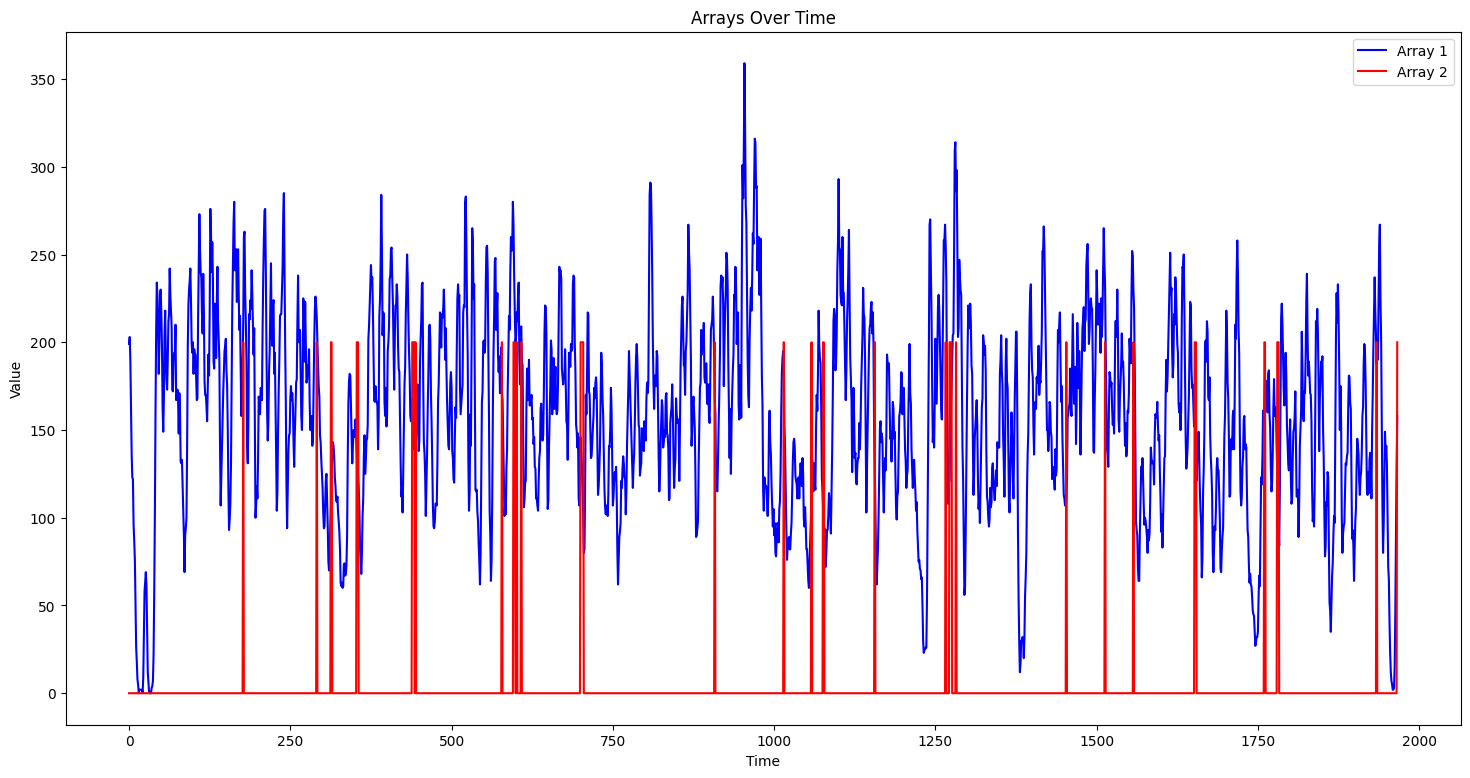

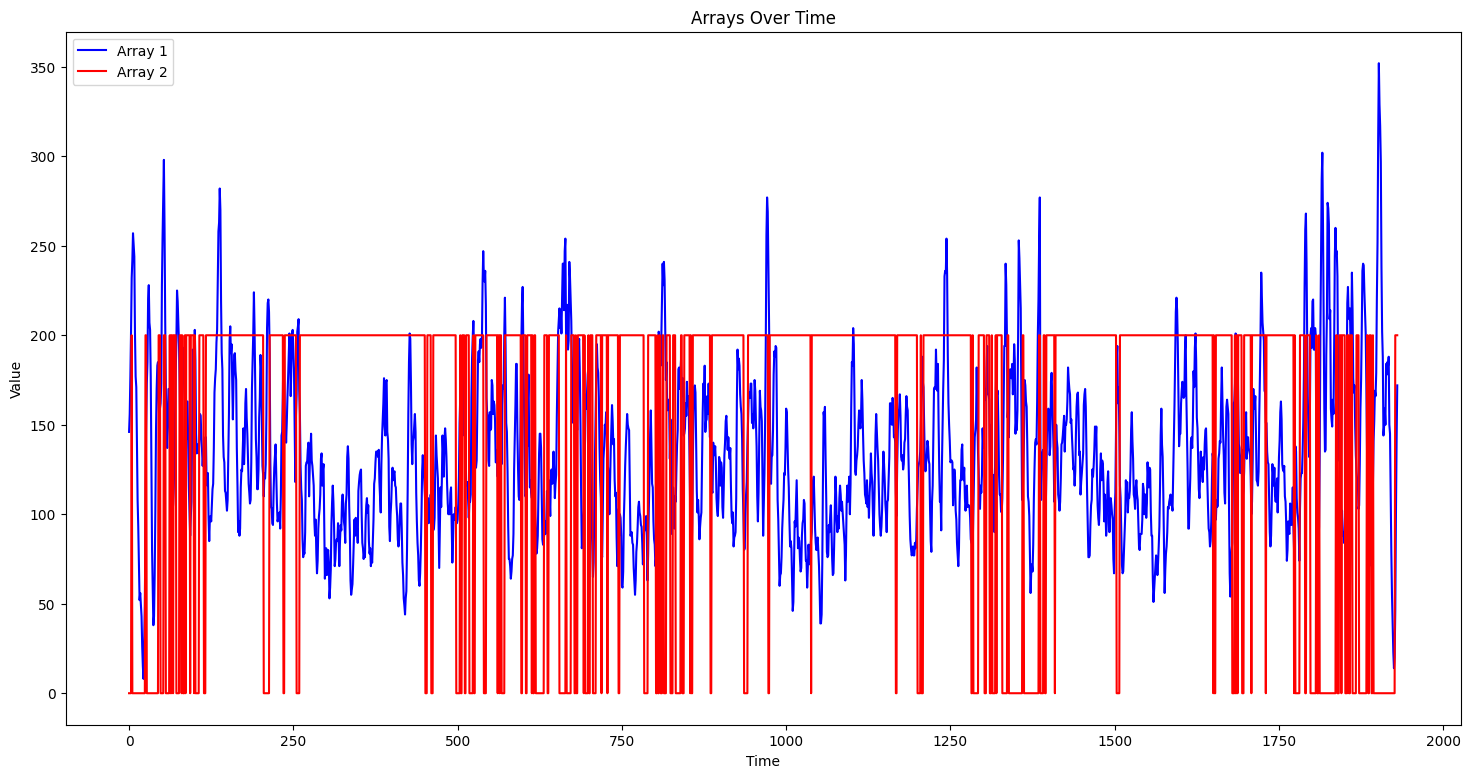

In [26]:
# Plot to visualize counts and GT superposed
plot_superposition(counts_for_GMAC_ndh, 200*GT_mask_NDH_1Hz)
plot_superposition(counts_for_GMAC_dh, 200*GT_mask_DH_1Hz)

## Individual Optimization

In [27]:
from individual_analysis_gmac_function import *

In [28]:
# Perform k-fold cross-validation for the left wrist data
# Return average optimal Count threshold, Pitch threshold and evaluation metrics on this optimal parameter when tested against GT
eval_metrics_opt_ndh, opt_thresholds_ndh = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_ndh.ravel(), mean_pitch_NDH['pitch'].values), axis=0).T, y=GT_mask_NDH_1Hz, optimal=True)
# Same but for conventional fixed threshold 
eval_metrics_conv_ndh, conv_thresholds_ndh = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_ndh.ravel(), mean_pitch_NDH['pitch'].values), axis=0).T, y=GT_mask_NDH_1Hz, optimal=False)

Arrays already had same shape.
Iteration 1/5
Optimal Count Threshold: 103.00
Optimal Pitch Threshold: 16.00
Iteration 2/5
Optimal Count Threshold: 101.00
Optimal Pitch Threshold: 15.00
Iteration 3/5
Optimal Count Threshold: 101.00
Optimal Pitch Threshold: 15.00
Iteration 4/5
Optimal Count Threshold: 101.00
Optimal Pitch Threshold: 15.00
Iteration 5/5
Optimal Count Threshold: 101.00
Optimal Pitch Threshold: 15.00
Arrays already had same shape.
Iteration 1/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 2/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 3/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 4/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 5/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00


In [29]:
# Perform k-fold cross-validation for the right wrist data
# Return average optimal Count threshold, Pitch threshold and evaluation metrics on this optimal parameter when tested against GT
eval_metrics_opt_dh, opt_thresholds_dh = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_dh, mean_pitch_DH['pitch'].values), axis=0).T, y=GT_mask_DH_1Hz, optimal=True)
# Same but for conventional fixed threshold
eval_metrics_conv_dh, conv_thresholds_dh = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_dh, mean_pitch_DH['pitch'].values), axis=0).T, y=GT_mask_DH_1Hz, optimal=False)

Arrays already had same shape.
Iteration 1/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 32.00
Iteration 2/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 32.00
Iteration 3/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 32.00
Iteration 4/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 32.00
Iteration 5/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 33.00
Arrays already had same shape.
Iteration 1/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 2/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 3/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 4/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 5/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00


In [30]:
# Optimal AC thresholds for this participant 
print(opt_thresholds_ndh, opt_thresholds_dh)

(101.4, 15.2) (0.0, 32.2)


In [31]:
# Create a structure to save all the evaluation metrics 
metrics_dictionary_GMAC = create_metrics_dictionary(eval_metrics_conv_ndh, eval_metrics_conv_dh, eval_metrics_opt_ndh, eval_metrics_opt_dh)

In [32]:
metrics_dictionary_GMAC

{'OT_ndh_Sensitivity': 46.520202020202014,
 'OT_ndh_Specificity': 74.40616934579374,
 'OT_ndh_Accuracy': 73.76383668513711,
 'OT_ndh_YoudenIndex': 0.2092637136599577,
 'OT_dh_Sensitivity': 54.24932001409949,
 'OT_dh_Specificity': 75.73476126960283,
 'OT_dh_Accuracy': 59.29643464406689,
 'OT_dh_YoudenIndex': 0.29984081283702313,
 'CT_ndh_Sensitivity': 5.818181818181818,
 'CT_ndh_Specificity': 93.58797772431414,
 'CT_ndh_Accuracy': 91.45864817039303,
 'CT_ndh_YoudenIndex': -0.00593840457504029,
 'CT_dh_Sensitivity': 57.98668770799297,
 'CT_dh_Specificity': 67.0275846092528,
 'CT_dh_Accuracy': 60.07296729190934,
 'CT_dh_YoudenIndex': 0.2501427231724578}

In [33]:
# Add metrics for AC threshold evaluation to the JSON file 
add_attributes_to_participant(participant_data, metrics_dictionary_GMAC = metrics_dictionary_GMAC) 
# Add optimal AC parameter to the JSON file 
add_attributes_to_participant(participant_data, optimal_GMAC_NDH = opt_thresholds_ndh, optimal_GMAC_DH = opt_thresholds_dh) 

In [34]:
# Save the JSON file with the new fields 
save_to_json(participant_data, participant_path)

Data saved to: ../data/CreateStudy/S008/S008.json


## Laterality metrics
A Method for Quantifying Upper Limb Performance in Daily Life Using Accelerometers - PMC [Lang et al. 2017] \
_Only based on counts, not on pitch!_

In [1]:
#TODO remove frames in counts if dh or ndh is excluded --> same array length for magnitude calculation

In [32]:
# Bilateral Magnitude 
bilateral_magnitude = compute_bilateral_magnitude(counts_for_GMAC_ndh, counts_for_GMAC_dh)

ValueError: Activity counts arrays must have the same length.

In [ ]:
# Magnitude Ratio
magnitude_ratio = get_magnitude_ratio(counts_for_GMAC_ndh, counts_for_GMAC_dh)

In [ ]:
# Pots to visualize UL usage 
plot_distribution_ratio(magnitude_ratio, non_affected_hand = dominant_hand, saving_path = None)
plot_density(bilateral_magnitude, magnitude_ratio, non_affected_hand = dominant_hand, saving_path = None)